In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os
os.chdir("/home/zongchen/thinned_mfld")

import sys
sys.path.append("/home/zongchen/thinned_mfld")
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

from tqdm import tqdm

plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 18
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath, amsfonts}')

# plt.rc('font', family='Arial', size=12)
plt.rc('axes', titlesize=22, labelsize=22, grid=True)
plt.rc('lines', linewidth=2)
plt.rc('legend', fontsize=22, frameon=False)
plt.rc('xtick', labelsize=18, direction='in')
plt.rc('ytick', labelsize=18, direction='in')
plt.rc('figure', figsize=(6, 4), dpi=100)

In [ ]:
particle_num = 256
loading_freq = 1
seed_list = [0, 1, 2]
# seed_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
methods_list = ['random', 'false', 'kt']
bandwidth = 1.0
g = 0
dataset = 'covertype'

train_loss_trajectory_dict = {'kt': [], 'random': [], 'false': []}
test_loss_trajectory_dict = {'kt': [], 'random': [], 'false': []}
mmd_dict = {'kt': [], 'random': [], 'false': []}
thin_original_mse_dict = {'kt': [], 'random': [], 'false': []}


for method in methods_list:
    for seed in seed_list:
        if method == 'false' or method == 'random':
            dir = f"./results_server/neural_network_covertype/thinning_{method}/kernel_sobolev__step_size_0.01__bandwidth_1.0"
            dir += f"__step_num_50__g_0__particle_num_{particle_num}__noise_scale_0.001__zeta_0.0001__seed_{seed}__complete"
        else:
            dir = f"./results_server/neural_network_covertype/thinning_{method}/kernel_gaussian__step_size_0.01__bandwidth_{bandwidth}"
            dir += f"__step_num_50__g_{g}__particle_num_{particle_num}__noise_scale_0.001__zeta_0.0001__seed_{seed}__complete"
        train_loss_trajectory = jnp.load(f"{dir}/train_losses.npy")
        test_loss_trajectory = jnp.load(f"{dir}/test_losses.npy")
        mmd_trajectory = jnp.load(f"{dir}/mmd_path.npy")
        thin_original_mse = jnp.load(f"{dir}/thin_original_mse_path.npy")

        if seed == 0:
            train_loss_trajectory_dict[method] = train_loss_trajectory[:, None]
            test_loss_trajectory_dict[method] = test_loss_trajectory[:, None]
            mmd_dict[method] = mmd_trajectory[:, None][::loading_freq]
            thin_original_mse_dict[method] = thin_original_mse[:, None][::loading_freq]
        else:
            train_loss_trajectory_dict[method] = jnp.concatenate([train_loss_trajectory_dict[method], train_loss_trajectory[:, None]], axis=1)
            test_loss_trajectory_dict[method] = jnp.concatenate([test_loss_trajectory_dict[method], test_loss_trajectory[:, None]], axis=1)
            mmd_dict[method] = jnp.concatenate([mmd_dict[method], mmd_trajectory[:, None][::loading_freq]], axis=1)
            thin_original_mse_dict[method] = jnp.concatenate([thin_original_mse_dict[method], thin_original_mse[:, None][::loading_freq]], axis=1)


In [4]:
train_loss_trajectory_dict_mean = {'kt': [], 'random': [], 'false': []}
test_loss_trajectory_dict_mean = {'kt': [], 'random': [], 'false': []}
train_loss_trajectory_dict_ste = {'kt': [], 'random': [], 'false': []}
test_loss_trajectory_dict_ste = {'kt': [], 'random': [], 'false': []}
mmd_dict_mean = {'kt': [], 'random': [], 'false': []}
mmd_dict_ste = {'kt': [], 'random': [], 'false': []}
thin_original_mse_dict_mean = {'kt': [], 'random': [], 'false': []}
thin_original_mse_dict_ste = {'kt': [], 'random': [], 'false': []}

for method in methods_list:
    train_loss_trajectory_dict_mean[method] = np.nanmean(train_loss_trajectory_dict[method], axis=1)
    test_loss_trajectory_dict_mean[method] = np.nanmean(test_loss_trajectory_dict[method], axis=1)
    train_loss_trajectory_dict_ste[method] = np.nanstd(train_loss_trajectory_dict[method], axis=1) / np.sqrt(train_loss_trajectory_dict[method].shape[1])
    test_loss_trajectory_dict_ste[method] = np.nanstd(test_loss_trajectory_dict[method], axis=1) / np.sqrt(test_loss_trajectory_dict[method].shape[1])
    mmd_dict_mean[method] = np.nanmean(mmd_dict[method], axis=1)
    mmd_dict_ste[method] = np.nanstd(mmd_dict[method], axis=1) / np.sqrt(mmd_dict[method].shape[1])
    thin_original_mse_dict_mean[method] = np.nanmean(thin_original_mse_dict[method], axis=1)
    thin_original_mse_dict_ste[method] = np.nanstd(thin_original_mse_dict[method], axis=1) / np.sqrt(thin_original_mse_dict[method].shape[1])   



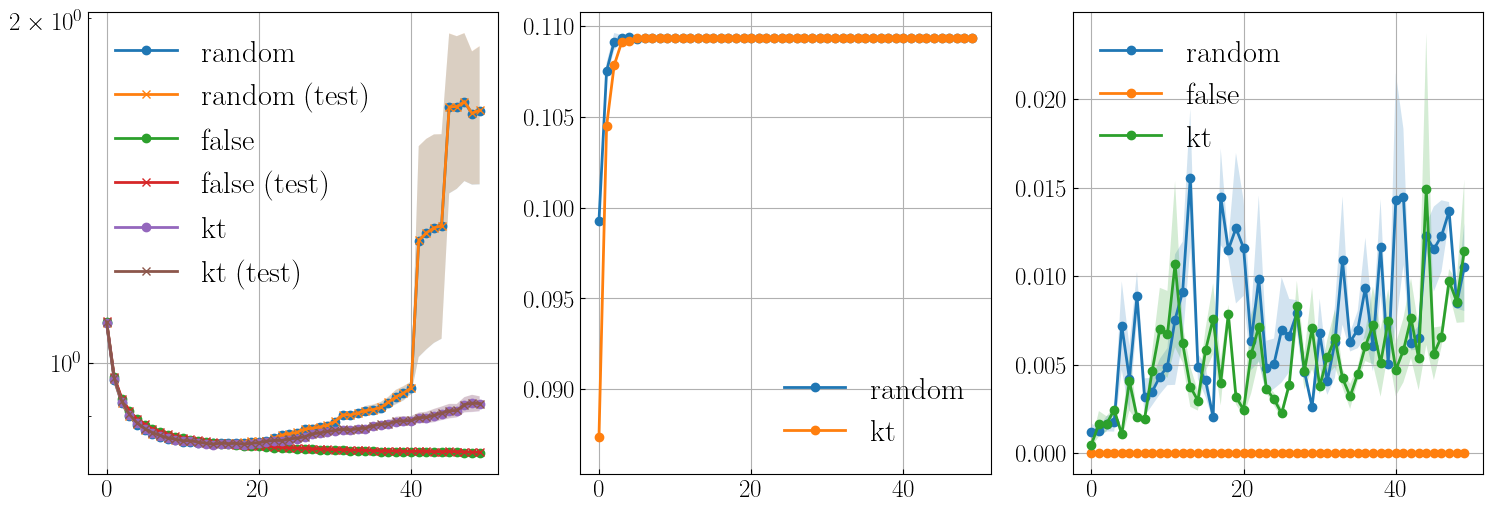

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].grid(True)

for method in methods_list:
    axs[0].plot(jnp.arange(train_loss_trajectory_dict_mean[method].shape[0]), train_loss_trajectory_dict_mean[method], label=method, marker='o')
    axs[0].fill_between(jnp.arange(train_loss_trajectory_dict_mean[method].shape[0]), train_loss_trajectory_dict_mean[method] - train_loss_trajectory_dict_ste[method], 
                        train_loss_trajectory_dict_mean[method] + train_loss_trajectory_dict_ste[method], alpha=0.2)
    axs[0].plot(jnp.arange(test_loss_trajectory_dict_mean[method].shape[0]), test_loss_trajectory_dict_mean[method], label=method + ' (test)', marker='x')
    axs[0].fill_between(jnp.arange(test_loss_trajectory_dict_mean[method].shape[0]), test_loss_trajectory_dict_mean[method] - test_loss_trajectory_dict_ste[method], 
                        test_loss_trajectory_dict_mean[method] + test_loss_trajectory_dict_ste[method], alpha=0.2)
    axs[0].legend()
    axs[0].set_yscale('log')

for method in methods_list:
    if method == 'false':
        continue
    axs[1].plot(jnp.arange(mmd_dict_mean[method].shape[0]), mmd_dict_mean[method], label=method, marker='o')
    axs[1].fill_between(jnp.arange(mmd_dict_mean[method].shape[0]), mmd_dict_mean[method] - mmd_dict_ste[method], 
                        mmd_dict_mean[method] + mmd_dict_ste[method], alpha=0.2)
    axs[1].legend()
    # axs[1].set_yscale('log')

for method in methods_list:
    axs[2].plot(jnp.arange(thin_original_mse_dict_mean[method].shape[0]), thin_original_mse_dict_mean[method], label=method, marker='o')
    axs[2].fill_between(jnp.arange(thin_original_mse_dict_mean[method].shape[0]), thin_original_mse_dict_mean[method] - thin_original_mse_dict_ste[method], 
                        thin_original_mse_dict_mean[method] + thin_original_mse_dict_ste[method], alpha=0.2)
    axs[2].legend()
plt.show()


In [6]:
test_loss_trajectory_dict_mean['kt'][-1]

np.float64(0.9219895996337798)

In [7]:
test_loss_trajectory_dict_mean['false'][-1]

np.float64(0.8362529182587908)

In [8]:
test_loss_trajectory_dict_mean['random'][-1]

np.float64(1.661851627129094)

In [9]:
test_loss_trajectory_dict_ste

{'kt': array([9.04291986e-04, 2.04033257e-03, 1.27547442e-03, 9.28791779e-04,
        7.29316020e-04, 8.29866087e-04, 2.00276028e-04, 2.89191797e-05,
        4.94428511e-04, 1.68997261e-04, 3.17961785e-04, 2.16294938e-04,
        3.34145566e-04, 2.30543724e-04, 4.08542204e-04, 9.51445641e-04,
        8.46784699e-04, 1.25857739e-03, 6.23689541e-04, 1.35694466e-03,
        9.28244775e-04, 8.40737991e-04, 1.91351687e-03, 2.38801021e-03,
        3.39810721e-03, 3.20693124e-03, 3.74876506e-03, 3.88489967e-03,
        2.39220925e-03, 3.53411517e-03, 3.06437033e-03, 2.99260109e-03,
        4.76881720e-03, 4.56205505e-03, 4.63579847e-03, 4.85239766e-03,
        5.37130350e-03, 6.27694629e-03, 8.37790217e-03, 8.85876575e-03,
        8.04390924e-03, 9.39203820e-03, 1.02504920e-02, 1.18600250e-02,
        1.22097464e-02, 1.31252660e-02, 1.21658154e-02, 1.40149843e-02,
        1.58251883e-02, 1.37632835e-02]),
 'random': array([1.08810674e-03, 2.07853476e-03, 1.61702454e-03, 1.39696288e-03,
      